# COMS 4701 Summer 2021: Homework 3

**Instructions**: Solve all problems and type up your solutions in this notebook. Each solution should appear in a new cell immediately following the given problem. Written problems should include work and steps in addition to the answers; $\LaTeX$ is highly recommended, but plaintext is also acceptable if it is understandable. You are highly encouraged to read through the accompanying tutorial first if you are new to $\LaTeX$. Coding solutions should be free of errors, and outputs should be left in the notebook for submission.

All submitted work must be your own. Cases of academic dishonesty will be addressed following the policies outlined on the [course syllabus](https://courseworks2.columbia.edu/courses/131236).

# Problem 1: Taking Up Arms (15 points)

In this problem you'll experiment with upper confidence bound (UCB) action selection for a multi-armed bandit (MAB) problem. The reward of each arm is drawn from a normal distribution with a different mean and variance. The agent does not know how the arm rewards are distributed, and the goal is to maximize the sum of rewards it receives over time.

The function below defines a three-armed bandit with provided mean, variance, and `c` (exploration weight) parameters. After trying each action once, the agent follows UCB to try an action 1000 more times. When finished, the program prints the number of times each action has been tried, and it plots both the action value estimates and UCB values over time.

In [3]:
import numpy as np
from matplotlib import pyplot as plt

def UCB_bandit(means, variances, c):
  Q = np.empty([1001, len(means)])
  Q[0,:] = [np.random.normal(mu, sigma) for mu, sigma in zip(means, variances)]
  N = np.ones(len(means))
  UCB = np.empty([1000, len(means)])

  for i in range(1,1001):
    UCB[i-1,:] = c*np.sqrt(np.divide(np.log(i),N))
    a = np.argmax(Q[i-1,:] + UCB[i-1,:])
    r = np.random.normal(means[a], variances[a])
    Q[i,:] = Q[i-1,:]
    Q[i,a] = (Q[i,a]*N[a] + r) / (N[a] + 1)
    N[a] += 1

  print("N: ", N)

  plt.figure()
  for i in range(len(means)):
    plt.plot(range(0,1001), Q[:,i], label="action "+str(i));
  plt.legend();
  plt.title("Q_t vs t");

  plt.figure()
  for i in range(len(means)):
    plt.plot(range(1,1001), UCB[:,i], label="action "+str(i));
  plt.legend();
  plt.title("UCB vs t");

In [ ]:
UCB_bandit([-2,0,2], [1,1,1], 1)
# UCB_bandit([-2,0,2], [1,1,5], 1)
# UCB_bandit([0,0,0], [1,1,1], 1)
# UCB_bandit([0,0,0], [5,5,5], 1)

Run `UCB_bandit` for each set of parameters above. You should run each scenario at least a few times to get a sense of what the results tend to look like, since the bandit rewards are not fixed. Then briefly describe your observations.

1.  Run `UCB_bandit` with the parameters `([-2,0,2], [1,1,1], 1)`. Which $Q_t$ sample estimates converge to the true mean values $Q^*$, and why do they not all converge? Of the UCB values, which generally decrease and which generally increase over time? How do your observations change if we increase the variance of the third arm to 5 (experiment with the parameters `([-2,0,2], [1,1,5], 1)`)?

2.  Experiment with the parameters `([0,0,0], [1,1,1], 1)`. Again, be sure to run the simulation several times. Do the convergence of the $Q_t$ values and behavior of the UCB values appear to be consistent over different runs? Why or why not? Comment on the observed distribution of ```N```, the numbers of times each action is tried.

3.  Consider again the parameters as in the previous part. How would you change `c` so as to ensure that all $Q_t$ converge in most if not all runs? What if the variances were all increased (e.g., to 5)? Find a value of `c` that ensures convergence for the parameters `([0,0,0], [5,5,5], c)` and show the output above.

ENTER YOUR RESPONSES HERE

1. 

2. 

3. 

# Problem 2: Battery Levels (15 points)

Suppose we have a robot vacuum cleaner whose battery level can be in one of three states: "high", "low", and "off". From the first two states, the robot can take either move slowly ($a_1$) or move quickly ($a_2$). From "off", the robot must recharge itself ($a_3$). Regardless of starting or ending state, $a_1$ yields a reward of $1$, $a_2$ yields $2$, and $a_3$ yields $-1$. The state transition diagram is shown below, and all outcomes of non-deterministic actions occur with probability $0.5$.

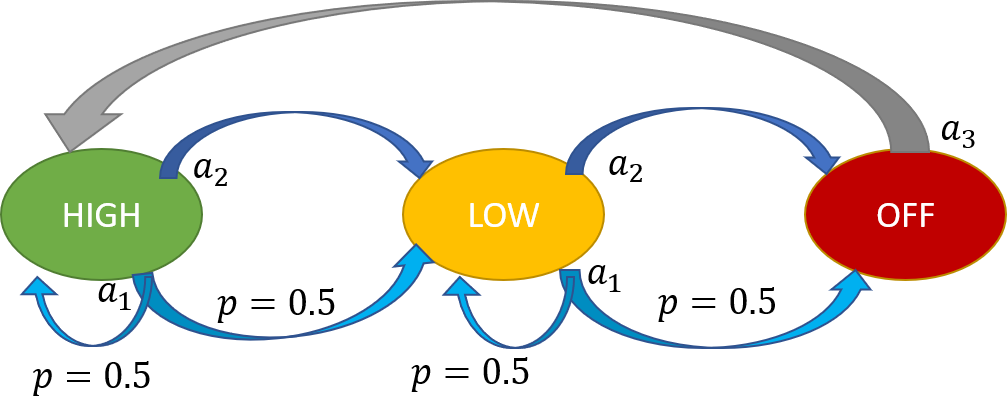

1. Write down and solve a system of linear equations that would give us the state values for the policy $\pi(\text{high}) = a_1$, $\pi(\text{low}) = a_2$, $\pi(\text{off}) = a_3$. Use a discount factor $\gamma = 0.5$.

2. Use the values you found above to improve the given policy by finding a different combination of actions that can lead to higher utilities in at least one state. Be sure to write down the equations you use. The two steps above constitute one round of policy iteration.

ENTER YOUR SOLUTIONS HERE

1.  

2.  


# Cliffworld: Dynamic Programming

In this portion you will explore sequential decision making in the gridworld with a cliff, or the "cliffworld". As shown in the accompanying figure, the cliffworld is a 4 by 12 grid, where the bottom row consists of a "cliff" along with a start and a goal. We would like our agent to learn to get from start to goal without falling into the cliff. All transitions incur a living reward of -1, except for transitions out of the cliff which incur a cost of -100. The goal state is terminal and has no associated actions.

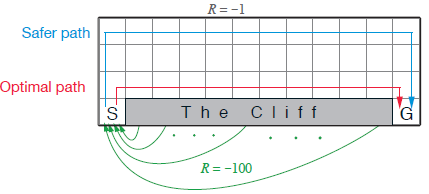

This problem is naturally represented as a MDP with each traversable cell as a state. Actions are left (<), right (>), up (^), and down (v); cliff states ('C') only have the action of teleporting to the start state. These are enumerated by the ```actions``` function . The cardinal direction actions are noisy; the agent moves in its intended direction with probability $p$ and in the two adjacent directions with probability $\frac12(1-p)$ each. When the agent moves into a wall, it stays in its original state. 

We have encoded all of this information for you in the ```Qvalue``` function below. A ```state``` is represented as a tuple of two indices that follow the same convention as a Numpy array; top left is (0,0), start is (3,0), and goal is (3,11). Given a ```state```, an ```action```, and a 2D numpy array of ```values```, the function computes the Q-value of taking ```action``` from ```state```, taking into account uncertainties, rewards, and successor state values. A discount factor ```gamma``` may also be applied.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

def actions(state):
  if state == (3,11): return ['G']
  if state[0] == 3 and 0 < state[1] < 11: return ['C']
  return ['<', '>', '^', 'v']

def Qvalue(state, action, values, p, gamma):
  """
  Compute the Q-value for the given state-action pair,
  given a set of values for the problem, with successful transition
  probability p and discount factor gamma.
  """
  i,j = state
  gV = gamma*values
  pn = (1-p)/2

  # Handle goal and cliff states
  if action == 'G':
    return 0
  if action == 'C':
    return -100 + gV[(3,0)]

  # All possible successor states
  left = (i,max(j-1,0))
  right = (i,min(j+1,11))
  up = (max(i-1,0),j)
  down = (min(i+1,3),j)

  # Q-value computation
  if action == '<':
    return p*(-1+gV[left]) + pn*(-1+gV[up]) + pn*(-1+gV[down])
  elif action == '>':
    return p*(-1+gV[right]) + pn*(-1+gV[up]) + pn*(-1+gV[down])
  elif action == '^':
    return p*(-1+gV[up]) + pn*(-1+gV[left]) + pn*(-1+gV[right])
  else:
    return p*(-1+gV[down]) + pn*(-1+gV[left]) + pn*(-1+gV[right])

## Coding 1 (15 points)

Value iteration can be used to obtain the optimal values for each state. Recall that the Bellman update, if using state-action values to update state values, looks like the following:

$$ V_{i+1}(s) \leftarrow \max_a Q_i(s,a) $$

Implement value iteration in the function below. An initial 2D array of ```values``` is provided, as well as the ```p``` and ```gamma``` parameters that ```Qvalue``` requires. The function should iteratively sweep over all state values and update them using the Bellman update; be sure that your updates are synchronous, which means that you should distinguish "new" and "old" values within a sweep. The process finishes when the maximum absolute difference in values between two successive sweeps is lower than ```threshold```. When finished, return the final array of converged state values.

In [ ]:
def value_iteration(values, p, gamma, threshold=1e-6):
  """
  INPUTS: An initial 2D Numpy array of state values, p and gamma parameters, 
  and stopping threshold for value iteration
  OUTPUTS: Converged 2D Numpy array of state values
  """
  # YOUR CODE HERE
  

## Coding 2 (10 points)

Now that we can compute optimal values, we can extract an optimal policy as well. Recall that this can be done using Q-values as follows:

$$ \pi^*(s) = \text{argmax}_a Q(s,a) $$

Implement this in ```extract_policy``` below. Following that we have a wrapper function that uses both functions to find the optimal values and policy together and prints them both out. 

In [ ]:
def extract_policy(values, p, gamma):
  """
  INPUTS: A 2D Numpy array of state values, p and gamma parameters
  OUTPUTS: A 2D Numpy array of containing the policy (each cell should contain
  an action, one of the following: '<', '>', '^', 'v')
  """
  # YOUR CODE HERE


def cliffworld_valueiter(p, gamma):
  # Find and show the optimal values and policy for the given parameters
  values = value_iteration(np.zeros((4,12)), p, gamma)
  policy = extract_policy(values, p, gamma) 
  np.set_printoptions(linewidth=100)
  print(np.round(values,2),"\n")
  print(policy,"\n")

You'll be running the following code cell for different values of ```p``` and ```gamma``` and analyzing the outputs, which consist of the optimal state values, the optimal policy, and a plot showing how ```max_diff``` varies over time (starting from the second iteration, since the first set of differences will be quite large). To check that your value iteration is implemented correctly, the values for $p=1$ and $\gamma=1$ are as follows:

```
[[ -14.  -13.  -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.]
 [ -13.  -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.   -2.]
 [ -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.   -2.   -1.]
 [ -13. -113. -113. -113. -113. -113. -113. -113. -113. -113. -113.    0.]]
```



In [ ]:
p = 1
gamma = 1
cliffworld_valueiter(p, gamma)

## Response 1 (10 points)
1. How do the state values change when you a) decrease $p$ and keep $\gamma$ fixed, and b) decrease $\gamma$ and keep $p$ fixed? To get a sense of the full range of possible outputs, remember that both values are lower-bounded by 0. Briefly explain your observations.

2. How does the policy change when you a) decrease $p$ and keep $\gamma$ fixed, and b) decrease $\gamma$ and keep $p$ fixed? Note that the policy is discrete, unlike the values, so you may only see a change occur if you hit a certain threshold in either value. Briefly explain your observations.

ENTER YOUR RESPONSES HERE

1. 

2. 

## Coding 3 (10 points)

Recall that an alternative approach to value iteration is policy iteration. This consists of alternating between evaluating a current policy and then improving it using the computed values. You have already implemented the second half of this in `extract_policy`. All that remains to be done is to implement a policy evaluation procedure.

Implement `evaluate_policy` below. It should solve for the values of the given policy using an **iterative** approach, using the provided values as initialization. Note that this procedure will look very similar to value iteration, except that there is no max operation. In other words, implement the following update:

$$ V^\pi_{i+1}(s) \leftarrow Q_i(s,\pi(s)) $$

In [ ]:
def evaluate_policy(policy, values, p, gamma, threshold=1e-6):
  """
  INPUTS: 2D Numpy arrays containing policy and initial state values, 
  p and gamma parameters, and stopping threshold for policy evaluation
  OUTPUTS: Converged 2D Numpy array of state values
  """
  # YOUR CODE HERE



def policy_iteration(policy, values, p, gamma):
  # Policy iteration wrapper function
  while True:
    values = evaluate_policy(policy, values, p, gamma)
    new_policy = extract_policy(values, p, gamma)
    if np.equal(new_policy, policy).all():
      return policy, values
    policy = new_policy

def cliffworld_policyiter(p, gamma):
  # Find and show the optimal values and policy for the given parameters
  init = extract_policy(np.zeros((4,12)), p, gamma)
  policy, values = policy_iteration(init, np.zeros((4,12)), p, gamma)
  np.set_printoptions(linewidth=100)
  print(np.round(values,2),"\n")
  print(policy,"\n")

The other functions above will take your implementation and run the policy iteration algorithm. You can test your results in the code cell below. Obviously, you should get the same results that you do using value iteration above. (Note that you may be unable to solve the problem if $\gamma=1$, an edge case that iterative policy evaluation cannot handle.)

In [ ]:
p = 1
gamma = .99
cliffworld_policyiter(p, gamma)

# Cliffworld: Reinforcement Learning

You hopefully now have a good understanding of the dynamics of this cliffworld. But our agent may be more clueless--let's suppose it no longer has access to the ```Qvalue``` function (the problem model). To find out what's going on in the world, it will actually have to take actions and learn from them à la reinforcement learning. We will use temporal difference learning, which explicitly keeps track of Q-values. These will be stored as a dictionary, where the key is a ```(state, action)``` tuple and the value is the Q-value. 

In RL, an agent has to balance exploitation and exploration. A simple way to do so is to use $\varepsilon$-greedy action selection. Remember that in this scheme, an agent selects a random action with probability $\varepsilon$ and the best action (the one with the highest Q-value in the given state) otherwise. 

During learning, the agent repeatedly takes an action from its current state, observes the successor state and reward, and repeats. If the agent encounters a terminal state (here, cliff or goal), we consider the episode over, and it goes back to the start. The ```step``` function below returns the successor state and associated reward after taking ```action``` from ```state```. This is essentially a black box to the agent, as it has no idea what is inside.

In [ ]:
import random

def epsilon_greedy_action(Qvalues, state, epsilon):
  # Explore a random action from state with probability epsilon
  # Otherwise, greedily choose the best action
  if random.random() < epsilon:
    return random.choice(actions(state))
  else:
    Qvalue = -float("inf")
    for a in actions(state):
      if Qvalues[(state, a)] > Qvalue:
        action = a
        Qvalue = Qvalues[(state, a)]
    return action  

def step(state, action, p):
  # Return successor state and reward upon taking action from state
  i,j = state
  if action == 'C':
    return (3,0), -100

  if action == '<':
    if random.random() < p: return (i,max(j-1,0)), -1
    else: return random.choice([(max(i-1,0),j), (min(i+1,3),j)]), -1
  if action == '>':
    if random.random() < p: return (i,min(j+1,11)), -1
    else: return random.choice([(max(i-1,0),j), (min(i+1,3),j)]), -1
  if action == '^':
    if random.random() < p: return (max(i-1,0),j), -1
    else: return random.choice([(i,max(j-1,0)), (i,min(j+1,11))]), -1
  else:
    if random.random() < p: return (min(i+1,3),j), -1
    else: return random.choice([(i,max(j-1,0)), (i,min(j+1,11))]), -1

In class we talk about two approaches to TD learning: SARSA and Q-learning. The Q-value update for SARSA is as follows:

$$ Q(s,a) \leftarrow Q(s,a) + \alpha(r + \gamma Q(s',a') - Q(s,a)) $$

Remember that $\alpha$ is the learning rate, and that $a'$ is an action selected for $s'$, again using epsilon-greedy selection. ```SARSA``` is implemented for you in its entirety below. Note that it uses the utility function ```extract_policy```, which uses Q-values and overloads the same function defined earlier for value iteration.

In [ ]:
def SARSA(Qvalues, p, gamma, alpha, epsilon, episodes=50000):
  # SARSA temporal difference learning using initial Qvalues and given parameters
  # Returns a learned policy (Numpy 2d array)
  for i in range(episodes):
    state = (3,0)
    action = epsilon_greedy_action(Qvalues, state, epsilon)
    while state != (3,11):
      next_state, reward = step(state, action, p)
      next_action = epsilon_greedy_action(Qvalues, next_state, epsilon)
      target = Qvalues[(next_state, next_action)]
      Qvalues[(state, action)] += alpha * (reward + gamma*target - Qvalues[(state, action)])
      state = next_state
      action = next_action
  policy = extract_policy(Qvalues)
  return policy

def extract_policy(Qvalues):
  # Extract the optimal policy associated with the given Q-values
  policy = np.empty((4,12), dtype=object)
  for i in range(4):
    for j in range(12):
      policy[i,j] = epsilon_greedy_action(Qvalues, (i,j), 0)
  return policy

## Coding 4 (10 points)

The other temporal difference learning approach is Q-learning, which is very similar to SARSA but uses the following Q-value update:

$$ Q(s,a) \leftarrow Q(s,a) + \alpha(r + \gamma \max_{a'} Q(s',a') - Q(s,a)) $$

Unlike SARSA, Q-learning uses the optimal action in the successor state for the update, even if that's not what the agent actually does. Given the above implementation for SARSA, use it to help with the implementation of ```Qlearner``` below. Note that the code should be very similar between the two; you should only have to change a few lines. You can also compute the action corresponding to the highest Q-value easily by calling ```epsilon_greedy_action``` with ```epsilon``` set to 0 (no exploration).


In [ ]:
def Qlearner(Qvalues, p, gamma, alpha, epsilon, episodes=50000):
  # Q-learning using initial Qvalues and given parameters
  # Returns a learned policy (2D Numpy array)  
  # YOUR CODE HERE


Once you have ```Qlearner``` successfully implemented, you should be able to call the following function to compare the policies learned by each of the two approaches. Note that since reinforcement learning is sample-based, you may not get exactly the same results each time, even with a large number of episodes. So we suggest that you run each trial a few times to get a sense of the average results.


In [ ]:
def TD_learn(p, gamma, alpha, epsilon):
  Qvalues = {((i,j),a): 0 for i in range(4) for j in range(12) for a in actions((i,j))}
  policy = SARSA(Qvalues, p, gamma, alpha, epsilon)
  print("SARSA policy")   
  print(policy,"\n")
  
  Qvalues = {((i,j),a): 0 for i in range(4) for j in range(12) for a in actions((i,j))}
  policy = Qlearner(Qvalues, p, gamma, alpha, epsilon)
  print("Q-learning policy")  
  print(policy)

In [ ]:
p = 1
gamma = 1
alpha = 0.1
epsilon = 0.2
TD_learn(p, gamma, alpha, epsilon)

## Response 2 (15 points)

1. Compare the results of SARSA and Q-learning for the given parameters (specifically, $p = \gamma = 1$). The former outputs a "safer route" by going all the way up and around, while the latter outputs the optimal route by hugging the cliff (since this scenario is deterministic, only the states along the path between the start and goal states matter). Explain why even though the underlying model and environment are the same in each. What happens if we set $\varepsilon$ to 0? Why?

2. Reset $\varepsilon$ to 0.2 and change the underlying model by decreasing $p$ to 0.8. Which of the policies changes and why? 

3. Set $p$ back to 1. Which learning method is most impacted if we make the learning rate $\alpha$ very high (e.g., 0.8) and why?

ENTER YOUR RESPONSES HERE

1. 

2. 

3.  